<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/1D_Pitching_Moment_MLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Learning for Time Series Forecasting: Predict the Future with MLPs and LSTMs in Python**

#####We will discover how to develop a neural network model for a time series prediction problem using the Keras and pytorch deep learning library.


#####We want to phrase:
1. How to use Long Short-Term Memory (LSTM) Recurrent neural network for time series prediction in PyTorch.
2. How to frame time series prediction problems as regression problems (Multilayer Perceptron Regression or MLP) and develop a neural network model.
3. How to use the window approach to frame a time series prediction problem and develop a neural network model.

**Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# for LSTM
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# for MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

**Analytical Solution**

In [ ]:
# Defines the analytical solution
def oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t):
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))    # w is omega
    cos = np.cos(w*t + phi)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)            # e is epsilon
    exp = np.exp(e*t)
    y  = A*exp*cos                              # y is alpha
    return y

**Parameters**

In [ ]:
# Main
A       = 1
ro      = 1.20
v       = 858
s       = 0.00385
d       = 0.07
CM_q_a  = 0.15
CM_a    = -0.09
I       = 1.55e-4
phi     = 0

In [ ]:
# get the analytical solution over the full domain
t = np.linspace(0,0.3,300)
y = oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t)
print(t.shape, y.shape)

(300,) (300,)


In [ ]:
# creating the dataframe
dataframe = pd.DataFrame({'y':y})
# displaying the dataframe
print(dataframe)

#####With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 50% of the observations used to train my model, leaving the remaining 50% for testing the model.

In [ ]:
# split into train and test sets
# dataframe = dataframe.drop(['t'], axis=1)
# print(dataframe)
dataset = dataframe.values
dataset = dataset.astype('float32')
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

**Long Short-Term Memory (LSTM) to Predict 1D Pitching Moment Equation for Blunt-Body Entry Vehicles**

#####Usually time series prediction is done on a **window $(w)$**. That is, given data from time $t-w$ to time $t$, you are asked to predict for time $t+1$ (or deeper into the future). The size of window $w$ governs how much data you are allowed to look at when you make the prediction. This is also called the **look back period**.

#####On a long enough time series, multiple overlapping window can be created. It is convenient to create a function to generate a dataset of fixed window from a time series. Since the data is going to be used in a PyTorch model, the output dataset should be in PyTorch tensors:

In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

#####It is intentional to produce the “feature” and the “target” the same shape: For a window of **four** time steps, the “feature” is the time series from $t$ to $t+3$ and the target is from $t+1$ to $t+4$. What we are interested is $t+4$ but the information of $t+1$ to $t+3$ is useful in training.

In [ ]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

**LSTM Model**

In [ ]:
class OscModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
model = OscModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

**Training and Verifying LSTM Network**

In [ ]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

**LSTM prediction**

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset) * np.nan
    test_plot[train_size+lookback:len(dataset)] = model(X_test)[:, -1, :]

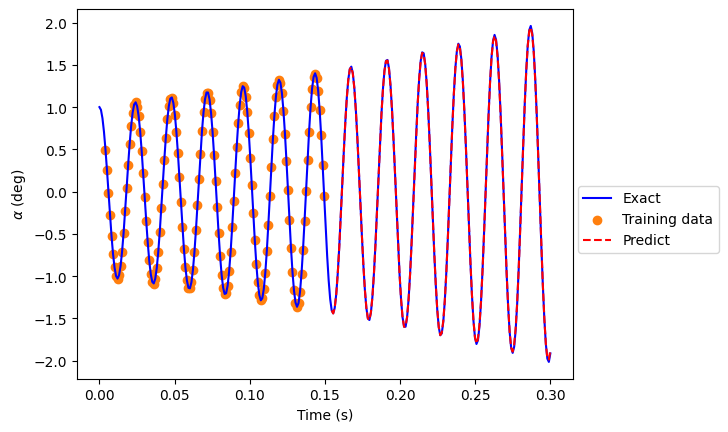

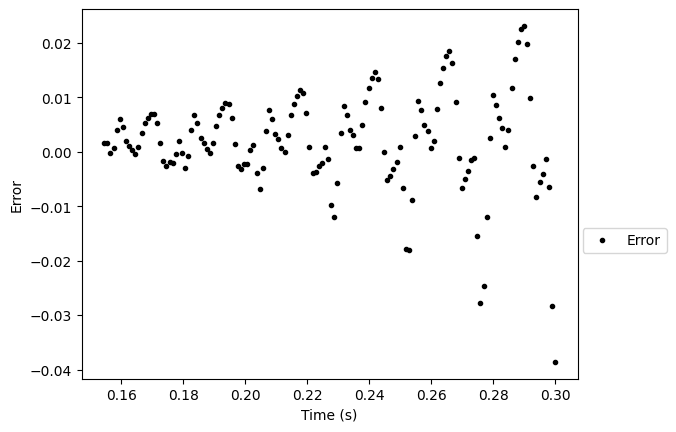

In [ ]:
# plot
plt.plot(t, dataset, "b",label="Exact")
plt.scatter(t, train_plot, label="Training data", color="tab:orange")
plt.plot(t, test_plot, '--r', label="Predict")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

plt.plot(t, dataset-test_plot, '.',color="black", label="Error")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend(loc=(1.01,0.34))
plt.show()

**Nonlinear Data**

In [ ]:
y_data = np.load('/content/sample_data/rdata_test.npy')

In [ ]:
# creating the dataframe
dataframe = pd.DataFrame({'y':y_data})
# displaying the dataframe
print(dataframe)

In [ ]:
# split into train and test sets
dataset = dataframe.values
dataset = dataset.astype('float32')
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [ ]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset) * np.nan
    test_plot[train_size+lookback:len(dataset)] = model(X_test)[:, -1, :]

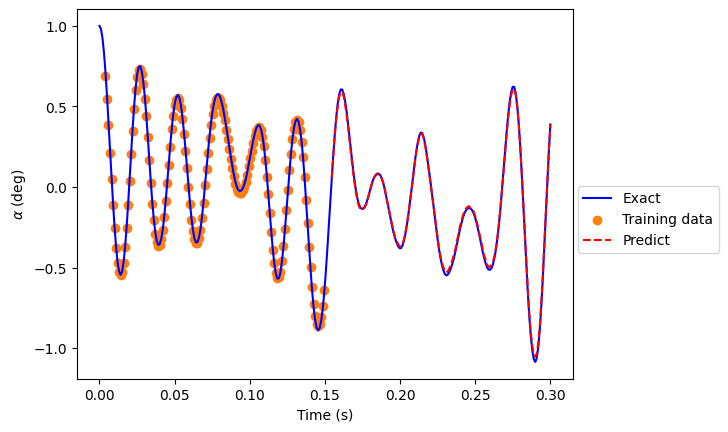

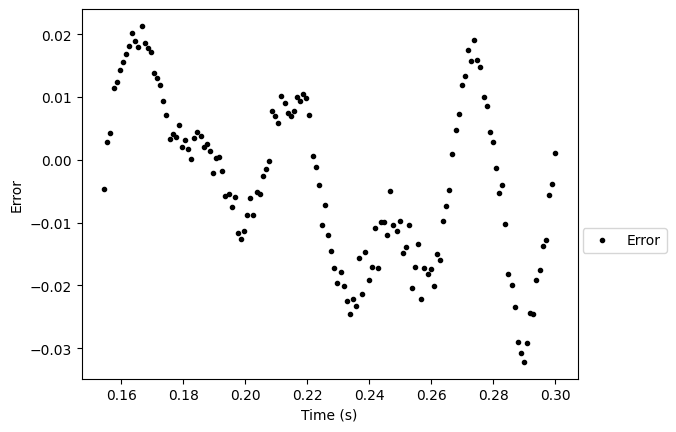

In [ ]:
# plot
plt.plot(t, dataset, "b",label="Exact")
plt.scatter(t, train_plot, label="Training data", color="tab:orange")
plt.plot(t, test_plot, '--r', label="Predict")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

plt.plot(t, dataset-test_plot, '.',color="black", label="Error")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend(loc=(1.01,0.34))
plt.show()

**Noisy Data**

In [ ]:
sig = 0.1
y_n = y_data + np.random.uniform(-sig,sig,y_data.shape)

In [ ]:
# creating the dataframe
dataframe_n = pd.DataFrame({'y':y_n})
# displaying the dataframe
print(dataframe_n)

In [ ]:
# split into train and test sets
dataset_n = dataframe_n.values
dataset_n = dataset_n.astype('float32')
train_size = int(len(dataset_n) * 0.5)
test_size = len(dataset_n) - train_size
train, test = dataset_n[0:train_size,:], dataset_n[train_size:len(dataset_n),:]
print(len(train), len(test))

In [ ]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [ ]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset_n) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset_n) * np.nan
    test_plot[train_size+lookback:len(dataset_n)] = model(X_test)[:, -1, :]

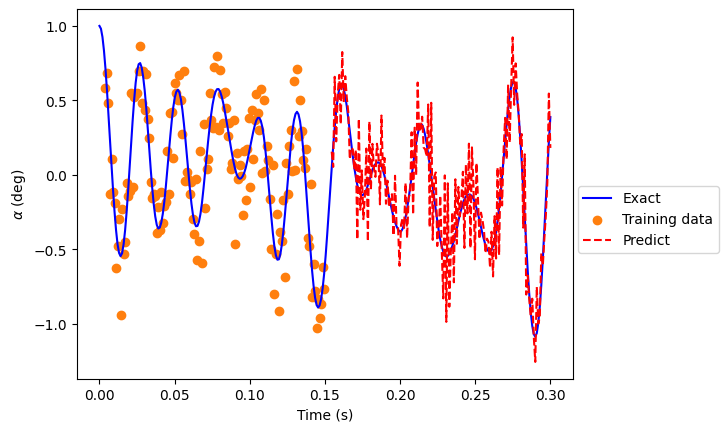

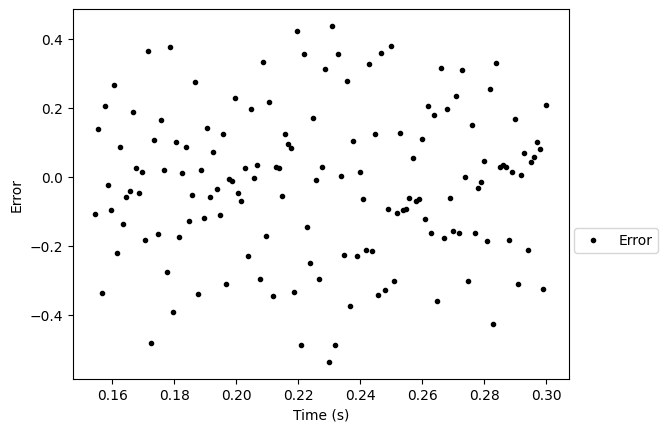

In [ ]:
# plot
plt.plot(t, dataset, "b",label="Exact")
plt.scatter(t, train_plot, label="Training data", color="tab:orange")
plt.plot(t, test_plot, '--r', label="Predict")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

plt.plot(t, dataset-test_plot, '.',color="black", label="Error")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend(loc=(1.01,0.34))
plt.show()

**Multilayer Perceptron Regression Using the Window Method to Predict 1D Pitching Moment Equation for Blunt-Body Entry Vehicles**

#####The **look_back** is the number of previous time steps to use as input variables to predict the next time period. For example, given the current time $t$ to predict the value at the next time in the sequence $t+1$, you can use the current time $t$ as well as the two prior times $t-1$ and $t-2$.

#####When phrased as a regression problem, the input variables are $t-2$, $t-1$, and $t$, and the output variable is $t+1$.

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 print(np.array(dataX).shape)
 print(np.array(dataY).shape)
 return np.array(dataX), np.array(dataY)

In [ ]:
create_dataset(dataset, look_back=1)

#####In this case, we set **look_back = 3 (y+1, given y, y-1, y-2)**. We can now fit a Multilayer Perceptron model to the training data. We use a simple network with three input, one hidden layer with eight neurons, and an output layer. The model is fit using mean squared error, which, if we take the square root, gives you an error score in the units of the dataset.

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

(147, 3)
(147,)
(147, 3)
(147,)


In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_shape=(look_back,), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.07 RMSE)


5/5 [==============================] - 0s 2ms/step


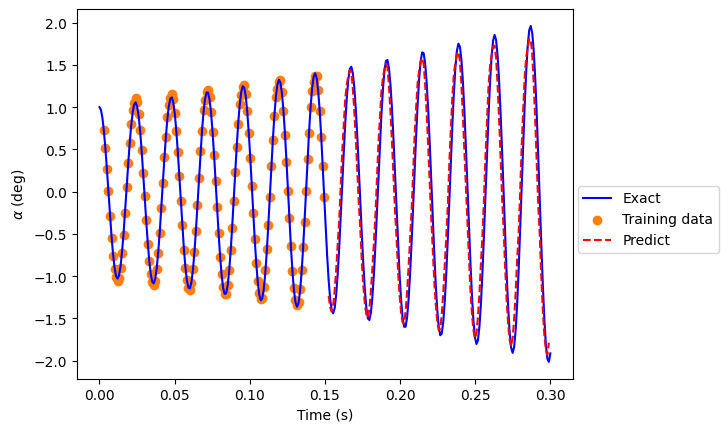

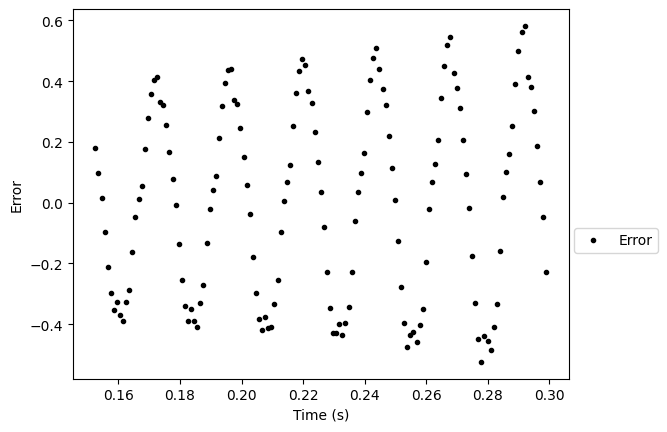

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(t, dataset, "b",label="Exact")
plt.scatter(t, trainPredictPlot, label="Training data", color="tab:orange")
plt.plot(t, testPredictPlot, '--r', label="Predict")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

plt.plot(t, dataset-testPredictPlot, '.',color="black", label="Error")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend(loc=(1.01,0.34))
plt.show()

#####Results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

**Nonlinear Data**

In [ ]:
y_data = np.load('/content/sample_data/rdata_test.npy')

In [ ]:
# creating the dataframe
dataframe = pd.DataFrame({'y':y_data})
# displaying the dataframe
print(dataframe)

In [ ]:
# split into train and test sets
dataset = dataframe.values
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_shape=(look_back,), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)


5/5 [==============================] - 0s 5ms/step


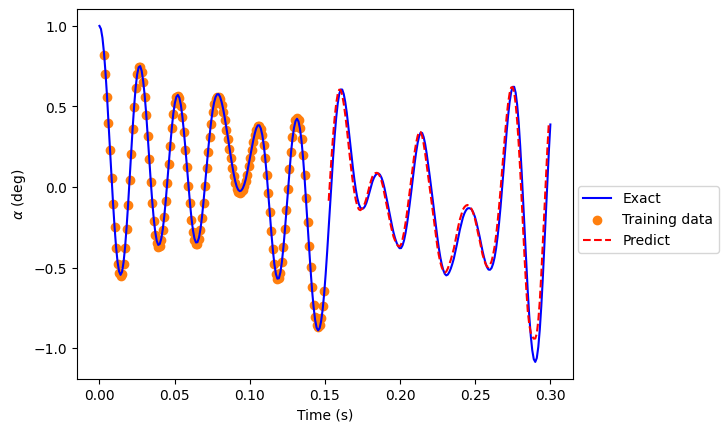

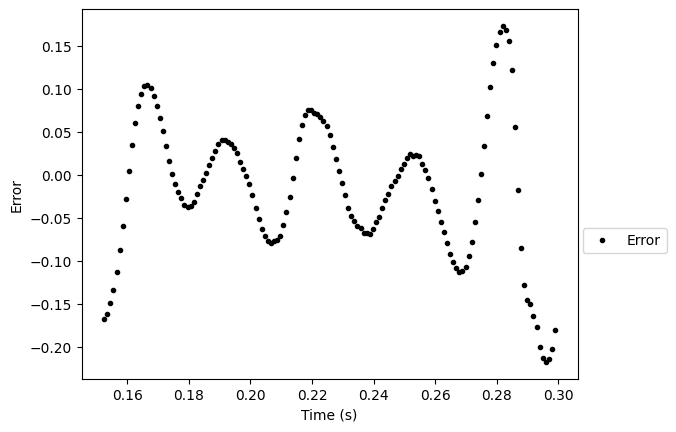

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(t, dataset, "b",label="Exact")
plt.scatter(t, trainPredictPlot, label="Training data", color="tab:orange")
plt.plot(t, testPredictPlot, '--r', label="Predict")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

plt.plot(t, dataset-testPredictPlot, '.',color="black", label="Error")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend(loc=(1.01,0.34))
plt.show()

**Noisy Data**

In [ ]:
sig = 0.1
y_n = y_data + np.random.uniform(-sig,sig,y_data.shape)

In [ ]:
# creating the dataframe
dataframe_n = pd.DataFrame({'y':y_n})
# displaying the dataframe
print(dataframe_n)

In [ ]:
# split into train and test sets
dataset_n = dataframe_n.values
train_size = int(len(dataset_n) * 0.5)
test_size = len(dataset_n) - train_size
train, test = dataset_n[0:train_size,:], dataset_n[train_size:len(dataset_n),:]
print(len(train), len(test))

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_shape=(look_back,), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

5/5 [==============================] - 0s 6ms/step


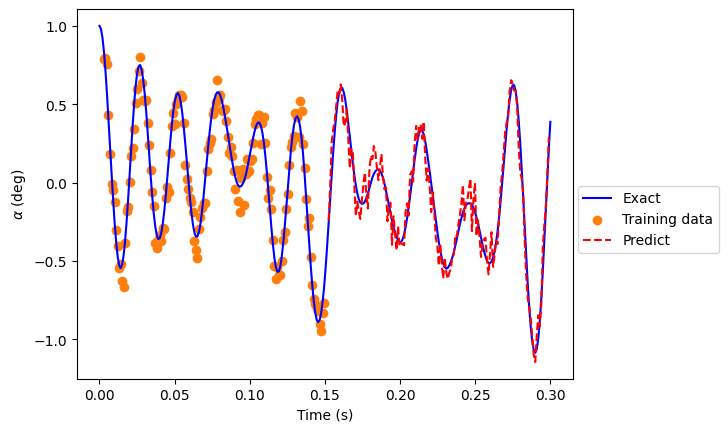

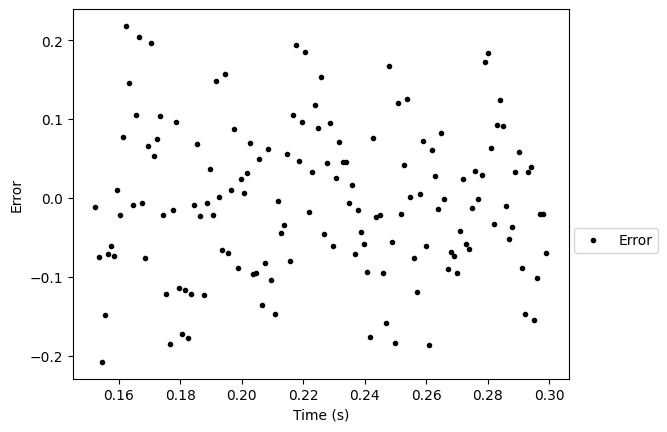

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_n)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_n)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset_n)-1, :] = testPredict
# plot baseline and predictions
plt.plot(t, dataset, "b",label="Exact")
plt.scatter(t, trainPredictPlot, label="Training data", color="tab:orange")
plt.plot(t, testPredictPlot, '--r', label="Predict")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

plt.plot(t, dataset-testPredictPlot, '.',color="black", label="Error")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend(loc=(1.01,0.34))
plt.show()